In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import shap

df_train = pd.read_csv("./preprocessed_heart_train_val.csv")
df_test = pd.read_csv("./preprocessed_heart_test.csv")

df_train

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Female,ChestPainType is _ATA,ChestPainType is _NAP,ChestPainType is _TA,RestingECG is _LVH,RestingECG is _ST,ST_Slope is _Down,ST_Slope is _Up
0,40.0,140.0,289.0,0.0,172.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,37.0,130.0,283.0,0.0,98.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,48.0,138.0,214.0,0.0,108.0,1.0,1.5,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54.0,150.0,195.0,0.0,122.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,39.0,120.0,339.0,0.0,170.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41.0,120.0,157.0,0.0,182.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
730,57.0,140.0,241.0,0.0,123.0,1.0,0.2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
731,45.0,110.0,264.0,0.0,132.0,0.0,1.2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
732,68.0,144.0,193.0,1.0,141.0,0.0,3.4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#Separate features and target
X_train = df_train.drop(columns=['HeartDisease'])
feature_names = list(X_train.columns)
print(feature_names)
X_test = df_test.drop(columns=['HeartDisease'])
y_train = df_train['HeartDisease']
y_test = df_test['HeartDisease']

X_test_before_scaling = X_test

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'Female', 'ChestPainType is _ATA', 'ChestPainType is _NAP', 'ChestPainType is _TA', 'RestingECG is _LVH', 'RestingECG is _ST', 'ST_Slope is _Down', 'ST_Slope is _Up']


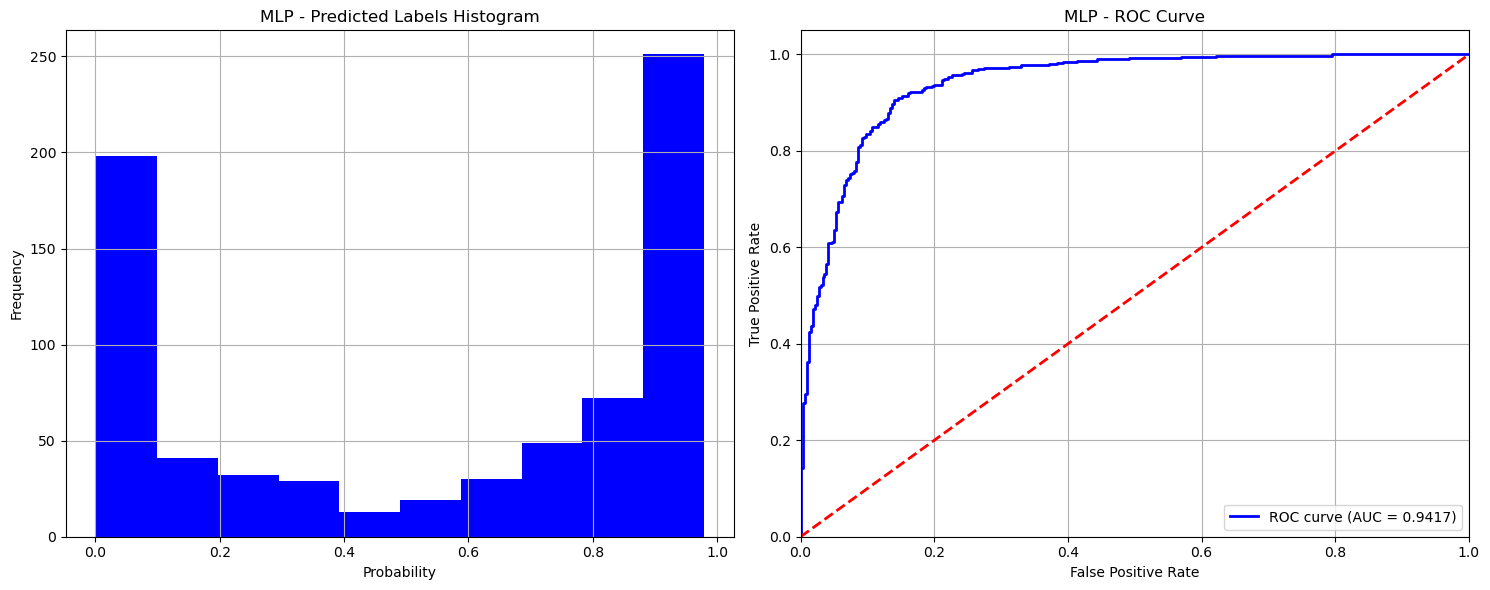

Optimal Threshold: 0.5655374294478728
F1-score: 0.8944099378881987
Balanced Accuracy: 0.8823208303421872


In [3]:
from sklearn.neural_network import MLPClassifier

# Train MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(8,), activation='relu', solver='adam', max_iter=5000, random_state=42)
mlp.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_mlp = mlp.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_mlp = roc_auc_score(y_test, y_prob_mlp)

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot predicted labels histogram
axes[0].hist(y_prob_mlp, color='b')
axes[0].set_title('MLP - Predicted Labels Histogram')
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot ROC curve
fpr_mlp, tpr_mlp, thresholds = roc_curve(y_test, y_prob_mlp)
axes[1].plot(fpr_mlp, tpr_mlp, color='b', lw=2, label='ROC curve (AUC = %0.4f)' % auc_mlp)
axes[1].plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('MLP - ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True)

plt.tight_layout()
plt.savefig('mlp_performance.svg', format='svg')
plt.show()

# Optimal Threshold based on ROC Curve
optimal_idx = np.argmax(tpr_mlp - fpr_mlp)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Threshold:',optimal_threshold)

y_pred_optimal = (y_prob_mlp >= optimal_threshold).astype(int)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)

print("F1-score:", f1)
print("Balanced Accuracy:", balanced_accuracy)

Confusion Matrix:
[[289  47]
 [ 38 360]]


TypeError: imshow() missing 1 required positional argument: 'X'

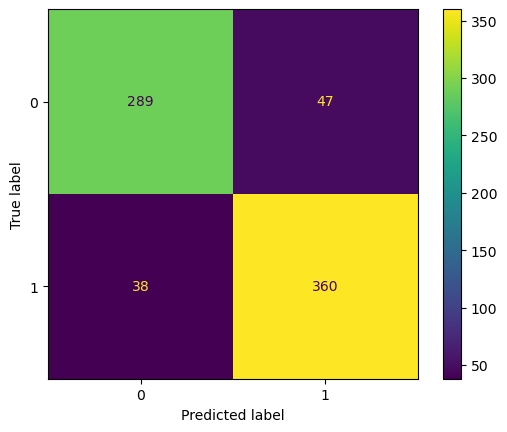

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
disp.plot()
plt.imshow()

In [ ]:
### CORRECT SHAP VALUES

In [5]:
# https://www.yourdatateacher.com/2021/05/17/how-to-explain-neural-networks-using-shap/
explainer = shap.KernelExplainer(mlp.predict,X_train)

Using 734 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [6]:
shap_values = explainer.shap_values(X_test,nsamples=100)
shap_values.shape

  0%|          | 0/734 [00:00<?, ?it/s]

(734, 15)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


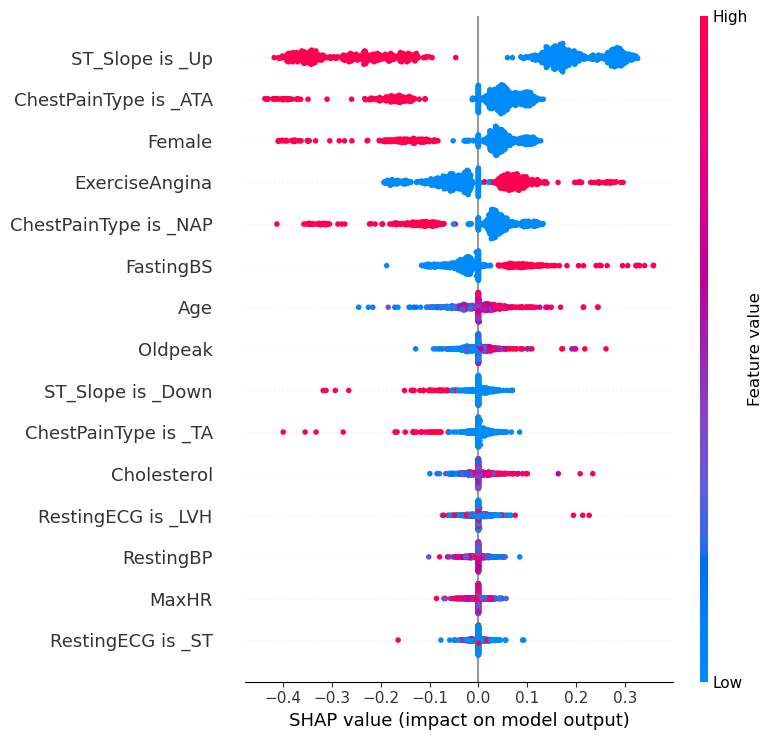

In [13]:
shap.summary_plot(shap_values,X_test,max_display=15, feature_names = feature_names)

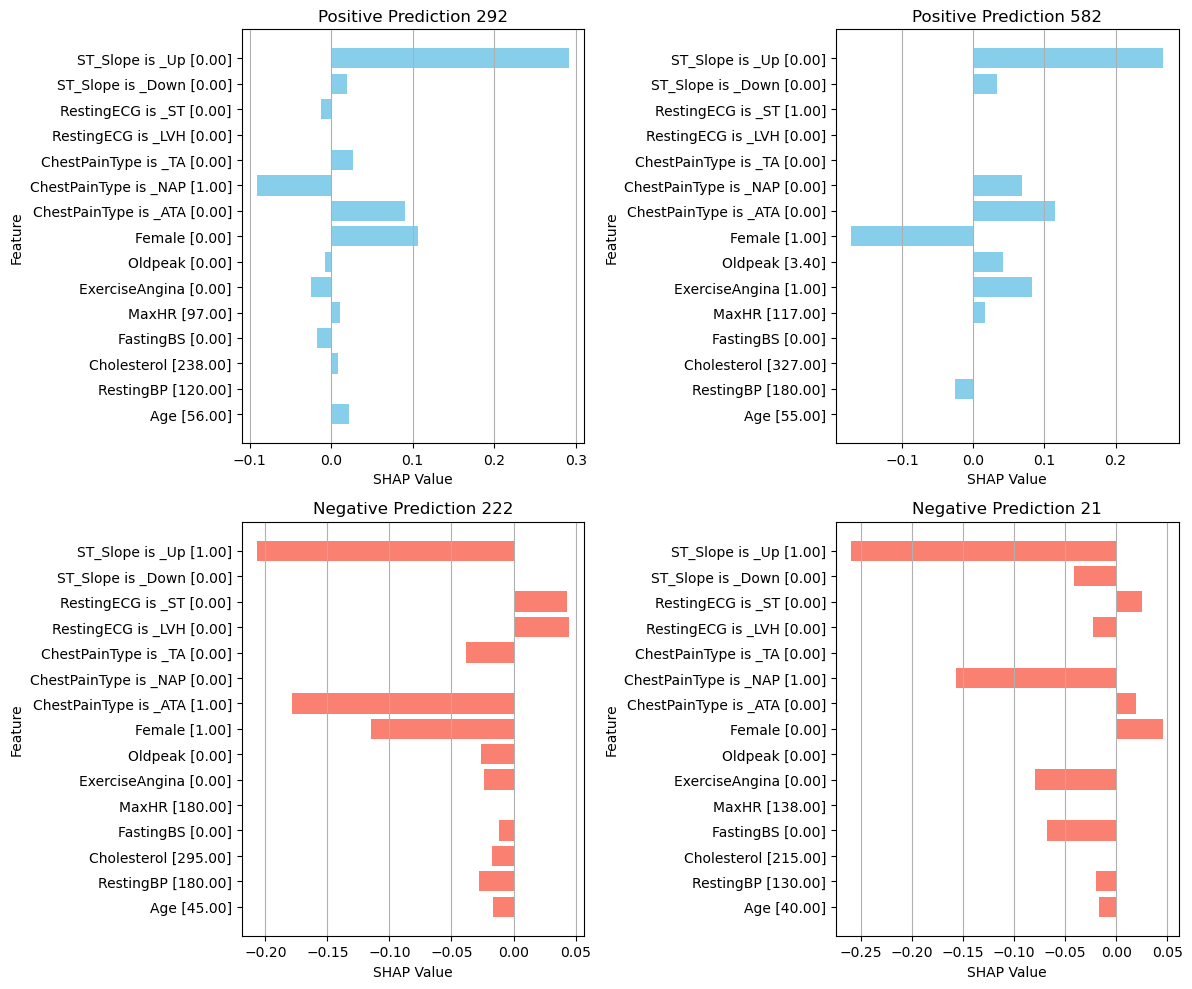

In [27]:
# Define function to format feature name with value
# Define function to format feature name with value
def format_feature_name(feature_name, feature_value):
    return f"{feature_name} [{feature_value:.2f}]"

# Define function to plot bar plots with feature values
def plot_bar_plots_with_values(shap_values, indices, title_prefix, ax):
    for i, (shap_values_instance, index) in enumerate(zip(shap_values, indices)):
        # Get feature values from test set for the corresponding index
        feature_values = X_test_before_scaling.loc[index]
        # Get feature names with values
        feature_names_with_values = [format_feature_name(feature_name, feature_values[feature_name]) for feature_name in feature_names]
        # Plot bar plot
        ax[i].barh(feature_names_with_values, shap_values_instance, color='skyblue' if title_prefix == 'Positive' else 'salmon')
        ax[i].set_xlabel('SHAP Value')
        ax[i].set_ylabel('Feature')
        ax[i].set_title(f'{title_prefix} Prediction {index}')
        ax[i].grid(axis='x')


# Get feature names
positive_indices = [292, 582]
negative_indices = [222, 21]

# Get the corresponding SHAP values
positive_shap_values = [shap_values[i] for i in positive_indices]
negative_shap_values = [shap_values[i] for i in negative_indices]

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot bar plots with feature values for positive predictions
plot_bar_plots_with_values(positive_shap_values, positive_indices, 'Positive', axes[0])

# Plot bar plots with feature values for negative predictions
plot_bar_plots_with_values(negative_shap_values, negative_indices, 'Negative', axes[1])

# Adjust layout
plt.tight_layout()
plt.show()